# Template-Based Chord Recognition Algorithm Implementation

## Normalization and chord recognition algorithm

We developed a chord recognition function using chromagrams and predefined chord templates. The function processes WAV files, computes chromagrams, calculates cosine similarity with templates, and identifies chord labels. Testing it on Beatles LetItBe.wav involves loading the audio and computing chord sequences.

In [1]:
import os
import numpy as np
from matplotlib import pyplot as plt
import matplotlib.image as mpimg
import librosa
import pandas as pd
import IPython.display as ipd
from scipy import signal
%matplotlib inline
import sklearn.metrics as metr

In [2]:
def normalize_feature_sequence(X, norm='2', threshold=0.0001, v=None):

    K, N = X.shape
    X_norm = np.zeros((K, N))

    #Manhattan norm
    if norm == '1':
        if v is None:
            v = np.ones(K, dtype=np.float64) / K
        for n in range(N):
            s = np.sum(np.abs(X[:, n]))
            if s > threshold:
                X_norm[:, n] = X[:, n] / s
            else:
                X_norm[:, n] = v
    #Euclidean norm (default)
    if norm == '2':
        if v is None:
            v = np.ones(K, dtype=np.float64) / np.sqrt(K)
        for n in range(N):
            s = np.sqrt(np.sum(X[:, n] ** 2))
            if s > threshold:
                X_norm[:, n] = X[:, n] / s
            else:
                X_norm[:, n] = v
    #Maximum norm
    if norm == 'max':
        if v is None:
            v = np.ones(K)
        for n in range(N):
            s = np.max(np.abs(X[:, n]))
            if s > threshold:
                X_norm[:, n] = X[:, n] / s
            else:
                X_norm[:, n] = v

    return X_norm

In [3]:
def complete_function(path, Fs = 22050, N = 4096, H = 2048, w_type='hamm', down_sampling=None, smoothing_window_length=None, norm_chrom = '2', norm_out = '2'):

    #loading of the wav file
    fn_wav = os.path.join('data', 'wav', path)
    x, Fs = librosa.load(fn_wav, sr=Fs)

    # Chromagram computation
    X = librosa.stft(x, n_fft=N, hop_length=H, pad_mode=None, center=False)
    X = np.abs(X) ** 2
    C = librosa.feature.chroma_stft(S=X, sr=Fs, tuning=0, hop_length=H, n_fft=N, norm=None)

    template_cmaj = np.array([[1, 0, 0, 0, 1, 0, 0, 1, 0, 0, 0, 0]]).T
    template_cmin = np.array([[1, 0, 0, 1, 0, 0, 0, 1, 0, 0, 0, 0]]).T

    templates = np.concatenate((template_cmaj, template_cmin), axis = 1)

    # initialize template matrix
    template_matrix = np.zeros((12, 12 * templates.shape[1]))

    for i in range(12):
        # shifting multiple columns of template matrix
        template_matrix[:, i::12] = np.roll(templates, i, axis=0)

    # Preprocessing

    # Normalization

    C_norm = normalize_feature_sequence(C, norm=norm_chrom)

    T_norm = normalize_feature_sequence(template_matrix, norm=norm_chrom)

    # Smoothing and downsampling
    nr, nc = C.shape
    C_smooth = np.zeros((nr, nc))
    if smoothing_window_length and down_sampling:
        # Convolution over time dimension
        #Perfoming 2D convolution with a window of type w_type.
        filt_kernel = np.expand_dims(signal.get_window(w_type, smoothing_window_length), axis=0)
        C_smooth = signal.convolve(C_norm, filt_kernel, mode='same') / smoothing_window_length
        C_norm = C_smooth[:, ::down_sampling]  #downsampling selection
        Fs = Fs / down_sampling  #new sampling frequency after downsampling

    # cosine similarity
    chord_similarity = np.matmul(T_norm.T, C_norm)

    if norm_out:
         CS_norm = normalize_feature_sequence(chord_similarity, norm=norm_out)

    # labels that maximize each column of the chord similarity
    chords_max_labels = (CS_norm == CS_norm.max(axis=0)).astype(int)

    #Labels of major chords
    chroma_label = ['C', 'C#', 'D', 'D#', 'E', 'F', 'F#', 'G', 'G#', 'A', 'A#', 'B']
    chord_label_maj = chroma_label
    #Labels of minor chords
    chord_label_min = [s + 'm' for s in chroma_label]
    #Template labels
    chord_labels = chord_label_maj + chord_label_min
    #Conversion in chord labels
    predicted_chords = []
    for i in range(chords_max_labels[0,:].size):
        v = np.where(chords_max_labels[:,i]== 1)
        predicted_chords.append(chord_labels[v[0][0]])

    return predicted_chords

In [4]:
predicted_labels = complete_function('Beatles_LetItBe.wav')
print(predicted_labels)

['G', 'C', 'C', 'C', 'C', 'C', 'C', 'C', 'C', 'C', 'C', 'C', 'C', 'C', 'C', 'C', 'C', 'C', 'C', 'G', 'G', 'G', 'G', 'G', 'G', 'G', 'G', 'G', 'G', 'G', 'G', 'G', 'G', 'G', 'G', 'G', 'G', 'Am', 'Am', 'Am', 'Am', 'Am', 'Am', 'Am', 'Am', 'Am', 'Am', 'Am', 'Am', 'Am', 'Am', 'C', 'C', 'Am', 'Am', 'F', 'Am', 'Am', 'Am', 'Am', 'Am', 'Am', 'Am', 'F', 'Dm', 'Dm', 'Dm', 'Dm', 'Dm', 'Dm', 'Dm', 'Dm', 'C', 'C', 'C', 'C', 'C', 'C', 'C', 'C', 'C', 'C', 'C', 'C', 'C', 'C', 'C', 'C', 'C', 'C', 'G', 'G', 'G', 'G', 'G', 'G', 'G', 'G', 'G', 'G', 'G', 'G', 'G', 'G', 'G', 'G', 'G', 'Dm', 'F', 'F', 'F', 'F', 'F', 'F', 'F', 'F', 'Em', 'Em', 'Em', 'Em', 'Em', 'Dm', 'Dm', 'Dm', 'Dm', 'Dm', 'C', 'C', 'C', 'C', 'C', 'C', 'C', 'C', 'C', 'C', 'C', 'C', 'C', 'C', 'C', 'Cm', 'G', 'C', 'C', 'C', 'C', 'C', 'C', 'C', 'C', 'Am', 'G#', 'C', 'C', 'C', 'C', 'C', 'C', 'Cm', 'G', 'G', 'Bm', 'G', 'G', 'G', 'G', 'G', 'G', 'G', 'Cm', 'G', 'G', 'G', 'G', 'G', 'G', 'G', 'Am', 'Dm', 'D', 'A', 'Am', 'Am', 'E', 'E', 'E', 'Am', 'Am', 

## Csv ground truth data

We developed a function to preprocess CSV reference annotation files for chord recognition tasks. It converts segment-based annotations into frame-based sequences, standardizes chord labels for enharmonic equivalence, and reduces the label set to match the recognition algorithm. We tested it on the Beatles LetItBe.csv file


In [18]:
def csv_gt_chord_labels (filepath, n_labels, Fs=22050, H = 2048):
    #Downloading data from file.csv
    csv_file = pd.read_csv('data/csv/' + filepath)
    #Storing column data in different lists
    starts = list(csv_file.Start)
    ends = list(csv_file.End)
    labels = list(csv_file.Label)

    #Defining time period
    T = H/Fs
    ground_truth_labels = []

    #Pre-processing

    #Converting the segment-based annotation into a frame-based label sequence
    for frame in range(n_labels):
        for i in range(len(csv_file)):
            #Selecting samples in i-th frame
             if ((frame*T) >= starts[i] and (frame*T) < ends[i]):
                #enharmonic equivalence
                chord= chord_conversion(labels[i])
                ground_truth_labels.append(chord)
                continue
    return ground_truth_labels

def chord_conversion(ch):


    chord = ch
    if "min" in chord:
        chord = chord[0] + "m"
    if "dim" in chord:
        chord = chord[0] + "m"
    if "maj" in chord:
        chord = chord[0]
    if  "/" in chord:
        chord = chord[0]
    if "sus" in chord:
        chord = chord[0]
    if ":" in chord:
        chord = chord[0]
    if (len(chord) > 1 and chord[1] == "b"):
        #Convert Ab in G#
        if (chord[0] == "A"):
            chord = "G#"
        else:
            #Ascii code evaluation to perform enharmonic equivalence
            chord = chr(ord(chord[0])-1)
            if (chord[0] != "B" and chord[0] != "E"):
                chord = chord + "#"
    if "#" in ch:
        chord = chord + "#"

    return chord

In [19]:
downloaded_chords = csv_gt_chord_labels('Beatles_LetItBe.csv', len(predicted_labels))
print(downloaded_chords)

['C', 'C', 'C', 'C', 'C', 'C', 'C', 'C', 'C', 'C', 'C', 'C', 'C', 'C', 'C', 'C', 'C', 'C', 'C', 'C', 'G', 'G', 'G', 'G', 'G', 'G', 'G', 'G', 'G', 'G', 'G', 'G', 'G', 'G', 'G', 'G', 'G', 'G', 'Am', 'Am', 'Am', 'Am', 'Am', 'Am', 'Am', 'Am', 'Am', 'Am', 'Am', 'Am', 'Am', 'Am', 'Am', 'Am', 'Am', 'Am', 'F', 'F', 'F', 'F', 'F', 'F', 'F', 'F', 'F', 'F', 'F', 'F', 'F', 'F', 'F', 'F', 'F', 'C', 'C', 'C', 'C', 'C', 'C', 'C', 'C', 'C', 'C', 'C', 'C', 'C', 'C', 'C', 'C', 'C', 'C', 'G', 'G', 'G', 'G', 'G', 'G', 'G', 'G', 'G', 'G', 'G', 'G', 'G', 'G', 'G', 'G', 'G', 'F', 'F', 'F', 'F', 'F', 'F', 'F', 'F', 'F', 'F', 'F', 'F', 'F', 'F', 'F', 'F', 'F', 'F', 'C', 'C', 'C', 'C', 'C', 'C', 'C', 'C', 'C', 'C', 'C', 'C', 'C', 'C', 'C', 'C', 'C', 'C', 'C', 'C', 'C', 'C', 'C', 'C', 'C', 'C', 'C', 'C', 'C', 'C', 'C', 'C', 'C', 'C', 'C', 'C', 'G', 'G', 'G', 'G', 'G', 'G', 'G', 'G', 'G', 'G', 'G', 'G', 'G', 'G', 'G', 'G', 'Am', 'Am', 'Am', 'Am', 'Am', 'Am', 'Am', 'Am', 'Am', 'Am', 'Am', 'Am', 'Am', 'Am', 'Am', '

## Accuracy

Definition of accurac function using sklearn.metrics.accuracy_score

In [9]:
def metrics(predicted_chords,downloaded_chords):
    accuracy = metr.accuracy_score(predicted_chords,downloaded_chords)
    return accuracy
accuracy = metrics(predicted_labels,downloaded_chords)
print('Accuracy of the algorithm performed over Beatles Let it be:',accuracy)

Accuracy of the algorithm performed over Beatles Let it be: 0.5248281130634072


## Computing Metric Values for Additional Beatles Songs

We calculate the metric for the remaining 3 Beatles songs: "Here Comes The Sun", "Penny Lane", and "Ob-La-Di, Ob-La-Da". We use the corresponding audio and CSV files located in the directories /data/wav/ and /data/csv/

In [10]:
#Evaluating metrics
predicted_labels = complete_function('Beatles_HereComesTheSun.wav')
downloaded_chords = csv_gt_chord_labels('Beatles_HereComesTheSun.csv', len(predicted_labels))
accuracy = metrics(predicted_labels,downloaded_chords)
print('Accuracy of the algorithm performed over Beatles Here Comes The Sun:',accuracy)

Accuracy of the algorithm performed over Beatles HereComesTheSun: 0.4727090635953931


In [11]:
predicted_labels = complete_function('Beatles_PennyLane.wav')
downloaded_chords = csv_gt_chord_labels('Beatles_PennyLane.csv', len(predicted_labels))
accuracy = metrics(predicted_labels,downloaded_chords)
print('Accuracy of the algorithm performed over Beatles Penny Lane:',accuracy)

Accuracy of the algorithm performed over Beatles Penny Lane: 0.36036492650785606


In [12]:
predicted_labels = complete_function('Beatles_ObLaDiObLaDa.wav')
downloaded_chords = csv_gt_chord_labels('Beatles_ObLaDiObLaDa.csv', len(predicted_labels))
accuracy = metrics(predicted_labels,downloaded_chords)
print('Accuracy of the algorithm performed over Beatles Ob-La-Di,Ob-La-Da:',accuracy)

Accuracy of the algorithm performed over Beatles Ob-La-Di,Ob-La-Da: 0.33661417322834647


## Parameter Impact on Templated Chord Recognition

We evaluate the performance of the template-based chord recognition algorithm by varying three different parameters individually. For each parameter, including smoothing filter length, we select three values and compute corresponding metric values for each song. By plotting the results, we observed how each parameter influences the algorithm's performance.

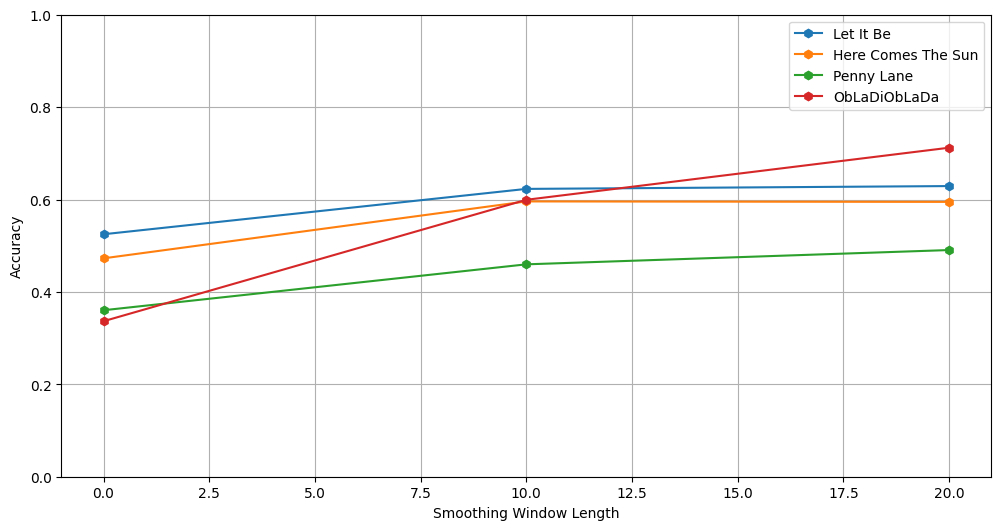

In [13]:
#Variation of the smoothing_window_length parameter:

name = ['Beatles_LetItBe','Beatles_HereComesTheSun','Beatles_PennyLane','Beatles_ObLaDiObLaDa']
#Initialization of accuracy list
acc1 = []

#Values of the smoothing_window_length parameter
L = [0,10,20]
#Setting D in order to avoid zero division in the algorithm's preprocessing phase
D = 1

#For cycle to evaluate the accuracy over all the songs listed in the name array
for i in range(len(name)):
    for l in L:
        predicted_labels = complete_function(name[i] + '.wav', down_sampling=D, smoothing_window_length = l)
        downloaded_chords = csv_gt_chord_labels(name[i] + '.csv', len(predicted_labels))
        acc = metrics(predicted_labels,downloaded_chords)
        acc1.append(acc)

plt.figure(figsize=(12,6))
plt.plot(L, acc1[0:3], marker='h', label = 'Let It Be')
plt.plot(L, acc1[3:6], marker='h', label = 'Here Comes The Sun')
plt.plot(L, acc1[6:9], marker='h', label = 'Penny Lane')
plt.plot(L, acc1[9:], marker='h', label = "ObLaDiObLaDa")
plt.legend(loc='best')
plt.grid()
plt.ylim([0,1])
plt.xlabel('Smoothing Window Length')
plt.ylabel('Accuracy')
plt.show()

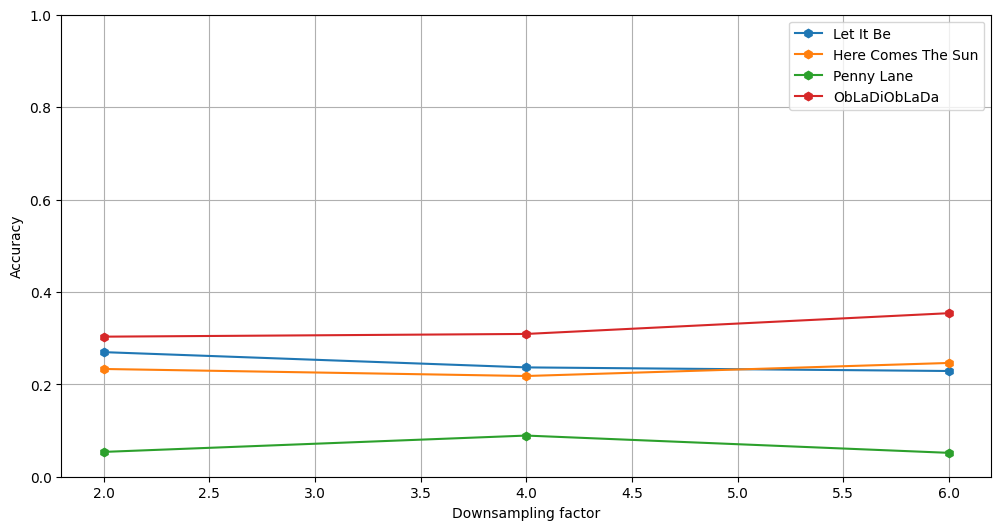

In [14]:
#Variation of the downsampling parameter:

acc2 = []

L = 10
D = [2,4,6]

for i in range(len(name)):
    for d in D:
        predicted_labels = complete_function(name[i] + '.wav', down_sampling=d, smoothing_window_length = L)
        downloaded_chords = csv_gt_chord_labels(name[i] + '.csv', len(predicted_labels))
        acc = metrics(predicted_labels,downloaded_chords)
        acc2.append(acc)


plt.figure(figsize=(12,6))
plt.plot(D, acc2[0:3], marker='h', label = 'Let It Be')
plt.plot(D, acc2[3:6], marker='h', label = 'Here Comes The Sun')
plt.plot(D, acc2[6:9], marker='h', label = 'Penny Lane')
plt.plot(D, acc2[9:], marker='h', label = "ObLaDiObLaDa")
plt.legend(loc='best')
plt.grid()
plt.ylim([0,1])
plt.xlabel('Downsampling factor')
plt.ylabel('Accuracy')
plt.show()

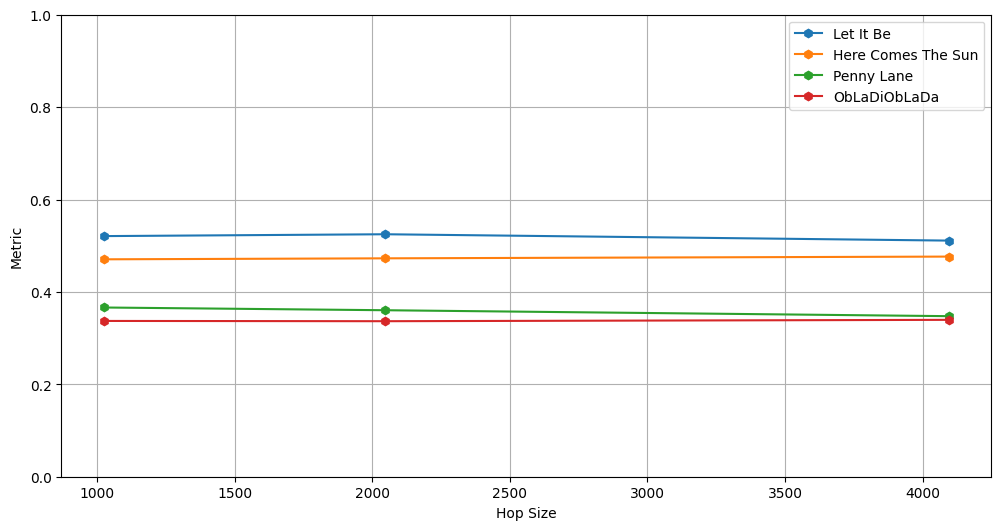

In [15]:
#Variation of the hop size parameter:

acc4 = []
N = 4096
H = [int(N),int(N/2),int(N/4)]

for i in range(len(name)):
    for h in H:
        predicted_labels = complete_function(name[i] + '.wav', H = h)
        downloaded_chords = csv_gt_chord_labels(name[i] + '.csv', len(predicted_labels), H = h)
        acc = metrics(predicted_labels,downloaded_chords)
        acc4.append(acc)

plt.figure(figsize=(12,6))
plt.plot(H, acc4[0:3], marker='h', label = 'Let It Be')
plt.plot(H, acc4[3:6], marker='h', label = 'Here Comes The Sun')
plt.plot(H, acc4[6:9], marker='h', label = 'Penny Lane')
plt.plot(H, acc4[9:], marker='h', label = "ObLaDiObLaDa")
plt.legend(loc='best')
plt.grid()
plt.ylim([0,1])
plt.xlabel('Hop Size')
plt.ylabel('Metric')
plt.show()